# Vision Transformers in Action
## Building and Training ViT to classify images


### Learning Objectives
- Understand how Vision Transformers process images as sequences
- Implement ViT from scratch using PyTorch
- Train on real datasets from Hugging Face

In [13]:
try:
    import google.colab
    !pip install transformers datasets torch torchvision matplotlib numpy pillow tqdm
    !pip install otter-grader==3.3.0
    !pip installece4078
    ON_COLAB = True
except:
    print("Running Locally")
    ON_COLAB = False

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.8/118.8 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.1 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math
from tqdm.auto import tqdm
from datasets import load_dataset
import random

# Set device and seeds for reproducibility
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
np.random.seed(42)
print(f"Using device: {device}")

Using device: cuda


## Part 1: Loading and Preparing Data

### 1.1 First let's download the `food101' Dataset from Hugging Face

If running locally, you can save time downloading the dataset by downloading from Google Drive via [this link](https://drive.google.com/file/d/1W_0BAmoT2gkSKf_vEiEJYUGLX8fKOBK_/view?usp=sharing) with Monash account. Unzip it and paste that to the `datasets` folder.

In [3]:
dataset_name = "food101"
def prepare_data(dataset_name=dataset_name):
    """Load dataset from Hugging Face and create data loaders"""

    # Load dataset
    train_dataset = load_dataset(dataset_name, split="train[:5000]")
    val_dataset = load_dataset(dataset_name, split="validation[:500]")

    dataset = load_dataset(dataset_name, split="train")
    dataset = dataset.shuffle(seed=42) # Shuffle for randomness
    dataset_small = dataset.select(range(5000)) # Select only 5000 samples
    splits = dataset_small.train_test_split(test_size=0.1, seed=42)     # Split into 90/10
    train_dataset = splits["train"]
    val_dataset = splits["test"]

    # class names
    class_names = dataset_small.features["label"].names

    train_transform = transforms.Compose([
        # Can add more data augmentation here
        # Suggestions: RandomHorizontalFlip, RandomCrop, ColorJitter
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return train_dataset, val_dataset, train_transform, val_transform, class_names

class ImageDataset(Dataset):
    """Custom dataset wrapper for the dataset"""

    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        label = item['label']

        if self.transform:
            image = self.transform(image)

        return image, label

# Load data
train_data, test_data, train_transform, val_transform, class_names = prepare_data()

# Create datasets
train_dataset = ImageDataset(train_data, train_transform)
test_dataset = ImageDataset(test_data, val_transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, persistent_workers=True)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Classes: {class_names}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00008.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

data/train-00001-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

data/train-00002-of-00008.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

data/train-00003-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

data/train-00004-of-00008.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

data/train-00005-of-00008.parquet:   0%|          | 0.00/470M [00:00<?, ?B/s]

data/train-00006-of-00008.parquet:   0%|          | 0.00/478M [00:00<?, ?B/s]

data/train-00007-of-00008.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

data/validation-00000-of-00003.parquet:   0%|          | 0.00/423M [00:00<?, ?B/s]

data/validation-00001-of-00003.parquet:   0%|          | 0.00/413M [00:00<?, ?B/s]

data/validation-00002-of-00003.parquet:   0%|          | 0.00/426M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

Training samples: 4500
Test samples: 500
Classes: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandw

Labels for displayed images:
clam_chowder  greek_salad  filet_mignon  chicken_wings  
hot_dog  chicken_curry  dumplings  cheesecake  
sushi  chicken_wings  ramen  hot_and_sour_soup  
chocolate_mousse  french_onion_soup  grilled_salmon  chicken_curry  


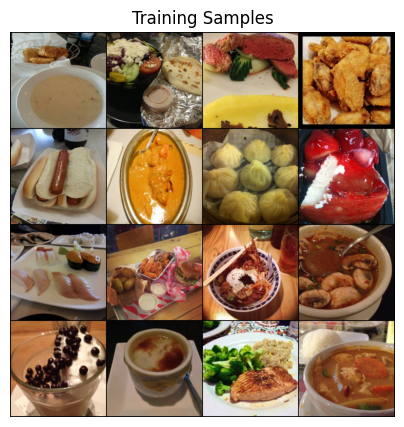

In [4]:
# Denormalize for visualization
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

def denormalize(tensor):
    return tensor * std + mean

def visualize_image_samples(images, labels):
    """Visualize some samples"""
    # Create grid
    grid = make_grid(denormalize(images), nrow=4, padding=2)

    plt.figure(figsize=(5, 5))
    plt.imshow(grid.permute(1, 2, 0).clamp(0, 1))
    plt.title("Training Samples")
    plt.axis('off')

    # Print labels
    print("Labels for displayed images:")
    for i in range(16):
        print(f"{class_names[labels[i]]}", end="  ")
        if (i + 1) % 4 == 0:
            print()

    plt.show()
# Get a batch of training data
data_iter = iter(train_loader)
images, labels = next(data_iter)
visualize_image_samples(images[:16], labels[:16])

## Part 2: Understanding ViT *Architecture*

### 2.1 Image Patches: From Pixels to Tokens

3 224 224
49


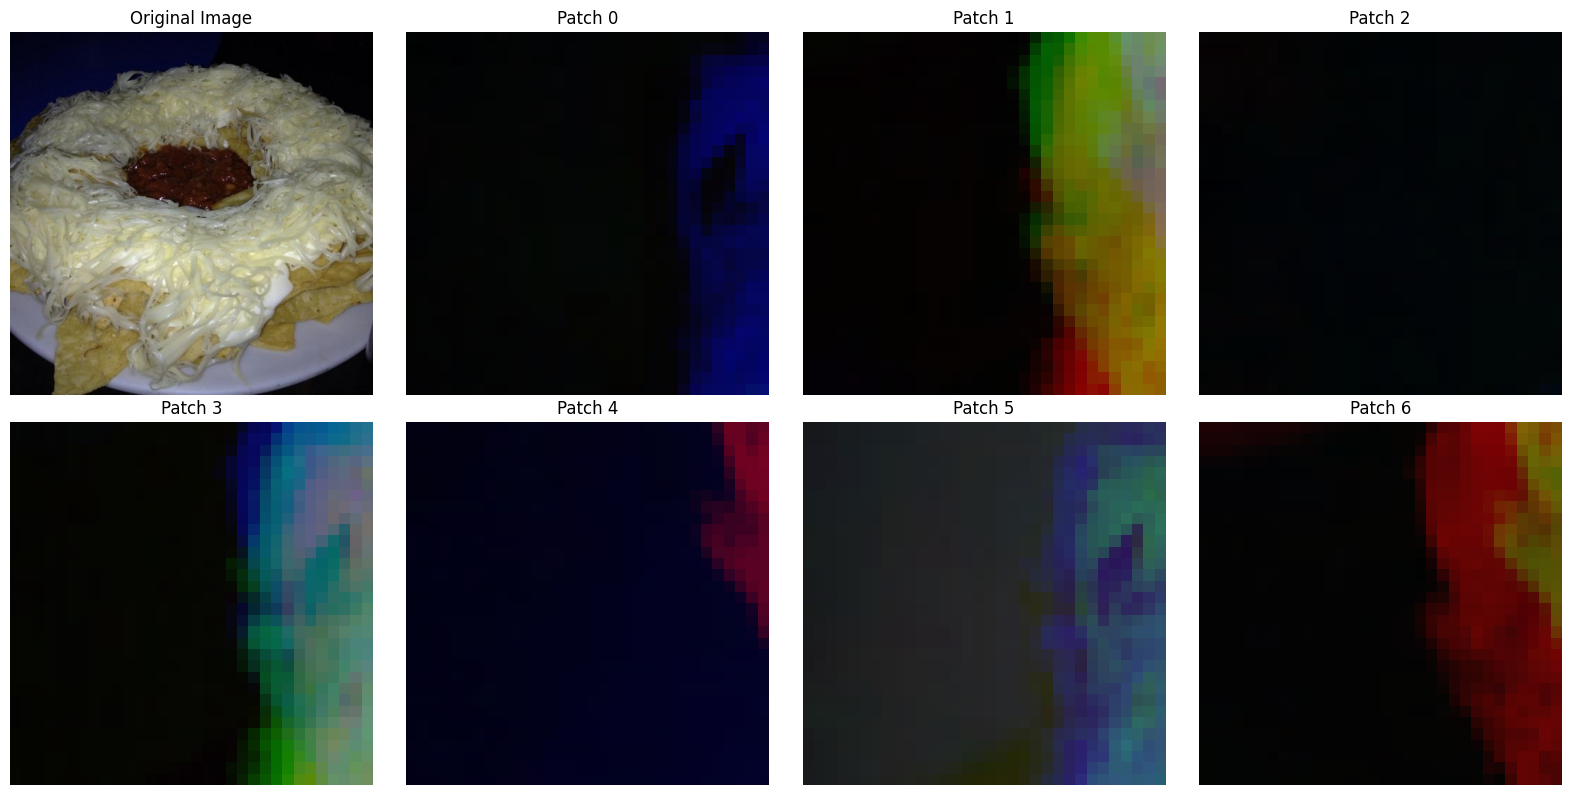

Image shape: torch.Size([3, 224, 224])
Number of patches: 49
Patch shape: torch.Size([3, 32, 32])


In [5]:
def extract_patches(image, patch_size=16):
    """Extract non-overlapping patches from image"""
    # image shape: (C, H, W)
    C, H, W = image.shape
    print(C,H,W)
    #TODO 1: Calculate number of patches and patches along the width (w) and heigh (h)
    num_patches_h = H // patch_size # YOUR CODE HERE
    num_patches_w = W // patch_size # YOUR CODE HERE
    patches = (
        image
        .unfold(1, patch_size, patch_size)
        .unfold(3, patch_size, patch_size)
    )
    patches = patches.permute(1, 3, 0, 2, 4)
    patches = patches.contiguous().view(-1, C, patch_size, patch_size)
 # YOUR CODE HERE
    #ENDTODO ------------------------------------------------------------

    return patches, num_patches_h, num_patches_w

transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
image = train_data[0]['image']
image_tensor = transform(image)

patches, num_h, num_w = extract_patches(image_tensor, patch_size=32)
print(len(patches))

# Visualize
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Original image
axes[0, 0].imshow(image)
axes[0, 0].set_title("Original Image")
axes[0, 0].axis('off')

# Show first few patches
for i in range(8):
    if i == 0:
        continue
    patch_idx = i - 1
    if patch_idx < len(patches):
        patch = patches[patch_idx].permute(1, 2, 0)
        row, col = divmod(i, 4)
        axes[row, col].imshow(patch)
        axes[row, col].set_title(f"Patch {patch_idx}")
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()

print(f"Image shape: {image_tensor.shape}")
print(f"Number of patches: {len(patches)}")
print(f"Patch shape: {patches[0].shape}")

### 2.2 The Model Architecture

In [14]:
class PatchEmbedding(nn.Module):
    """Convert image patches to embeddings"""

    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2

        #TODO 2: Implement patch embedding using convolution
        # Hint: Conv2d with kernel_size=patch_size, stride=patch_size
        self.projection = nn.Conv2d(
            in_channels,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        ) # YOUR CODE HERE
        #ENDTODO ------------------------------------------------------------


        # Learnable position embeddings
        self.position_embeddings = nn.Parameter(
            torch.randn(1, self.num_patches + 1, embed_dim) * 0.02
        )

        # Class token (like BERT's [CLS] token)
        self.class_token = nn.Parameter(torch.randn(1, 1, embed_dim) * 0.02)

    def forward(self, x):
        batch_size = x.shape[0]

        #TODO 2: Implement forward pass
        # 1. Extract patches using convolution # Output shape: (batch_size, embed_dim, num_patches_h, num_patches_w)
        # 2. Flatten spatial dimensions  (height, width) of the patches and transpose to the standard transformer format (batch_size, seq_len, embed_dim). # (B, E, H, W) -> (B, E, N) -> (B, N, E) where N is num_patches
        # 3. Add class token. Prepend the class token to the sequence of patches. Expand the class token to match the batch size.
        # 4. Add position embeddings. This is broadcasted across the batch dimension.

        # Extract patches
        x =  self.projection(x) # YOUR CODE HERE
        x =  x.flatten(2)
        x = x.transpose(1, 2)
         # YOUR CODE HERE: flatten and transpose

        # Add class token
        class_tokens = self.class_token.expand(batch_size, 1, -1) # YOUR CODE HERE
        x =  torch.cat([class_tokens, x], dim=1) # YOUR CODE HERE: concatenate

        # Add position embeddings
        x =  x + self.position_embeddings[:, :x.size(1), :] # YOUR CODE HERE
        #ENDTODO ------------------------------------------------------------

        return x

In [7]:
# The ViT Block
class ViTBlock(nn.Module):
    """Single Vision Transformer block"""

    def __init__(self, embed_dim=768, num_heads=12, mlp_ratio=4, dropout=0.1):
        super().__init__()

        # Multi-head self-attention
        self.attention = nn.MultiheadAttention(
            embed_dim, num_heads, dropout=dropout, batch_first=True
        )

        # MLP (Feed-forward)
        mlp_dim = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),  # ViT uses GELU instead of ReLU
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout)
        )

        # Layer normalization (pre-norm like in ViT)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        #TODO 4: Implement ViT block forward pass with pre-normalization
        # Note: ViT uses pre-norm (norm before attention/mlp) unlike original transformer

        # Self-attention with pre-norm
        residual = x
        x = self.norm1(x) # YOUR CODE HERE: apply norm1
        x, _ = self.attention(x, x, x, need_weights=False) # YOUR CODE HERE: apply attention  (query, key, and value are the same)
        x = residual + x # YOUR CODE HERE: add residual

        # MLP with pre-norm
        residual = x
        x = self.norm2(x) # YOUR CODE HERE: apply norm2
        x = self.mlp(x) # YOUR CODE HERE: apply mlp
        x = residual + x # YOUR CODE HERE: add residual
        #ENDTODO ------------------------------------------------------------

        return x

In [12]:
if not ON_COLAB:
    import otter
    from ece4078.Utility import pretty_print_otter
    grader = otter.Notebook(tests_dir = "Practical10_Support/tests")
    print(grader.check_all())

# [NOT GRADED] Vision Transformer in action

## 1. Putting it all together

In [9]:
class VisionTransformer(nn.Module):
    """Complete Vision Transformer implementation"""

    def __init__(self, img_size=224, patch_size=16, in_channels=3, num_classes=1000,
                 embed_dim=768, num_layers=12, num_heads=12, mlp_ratio=4, dropout=0.1):
        super().__init__()

        self.num_classes = num_classes
        self.embed_dim = embed_dim

        # Patch embedding
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)

        # Transformer blocks
        self.blocks = nn.ModuleList([
            ViTBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(num_layers)
        ])

        # Final layer norm
        self.norm = nn.LayerNorm(embed_dim)

        # Classification head
        self.head = nn.Linear(embed_dim, num_classes)

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        """Initialize weights following ViT paper"""
        if isinstance(module, nn.Linear):
            nn.init.trunc_normal_(module.weight, std=0.02)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.LayerNorm):
            nn.init.constant_(module.bias, 0)
            nn.init.constant_(module.weight, 1.0)

    def forward(self, x):
        # Patch embedding
        x = self.patch_embed(x)

        # Pass through transformer blocks
        for block in self.blocks:
            x = block(x)

        # Final norm
        x = self.norm(x)

        # Use class token for classification
        class_token = x[:, 0]

        # Classification
        output = self.head(class_token)

        return output

# Create model
model = VisionTransformer(
    img_size=224,
    patch_size=16,
    num_classes=len(class_names),
    embed_dim=384,   # Smaller for faster training
    num_layers=6,    # Smaller for demo
    num_heads=6
).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 11,057,765


## 2. Let's try supervised classification (Standard Training)

In [10]:
def train_supervised(model, train_loader, val_loader, num_epochs=5):
    """Standard supervised training for image classification"""

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.05)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    train_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_loss = 0

        for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}")):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Print progress every 100 batches
            if batch_idx % 100 == 0:
                print(f"Batch {batch_idx}, Loss: {loss.item():.4f}")

        # Validation phase
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        avg_loss = total_loss / len(train_loader)

        train_losses.append(avg_loss)
        val_accuracies.append(accuracy)

        scheduler.step()

        print(f"Epoch {epoch+1}: Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    return train_losses, val_accuracies

Starting supervised training...


Epoch 1:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 4.6195
Batch 100, Loss: 4.6840
Epoch 1: Loss: 4.6792, Accuracy: 1.00%


Epoch 2:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 4.5574
Batch 100, Loss: 4.3617
Epoch 2: Loss: 4.5733, Accuracy: 2.60%


Epoch 3:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 4.4979
Batch 100, Loss: 4.5657
Epoch 3: Loss: 4.4767, Accuracy: 2.80%


Epoch 4:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 4.1856
Batch 100, Loss: 4.2893
Epoch 4: Loss: 4.3311, Accuracy: 3.20%


Epoch 5:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 4.2321
Batch 100, Loss: 4.4286
Epoch 5: Loss: 4.2313, Accuracy: 4.80%


Epoch 6:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 3.9975
Batch 100, Loss: 4.1459
Epoch 6: Loss: 4.1430, Accuracy: 4.40%


Epoch 7:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 4.1875
Batch 100, Loss: 4.1422
Epoch 7: Loss: 4.0654, Accuracy: 4.00%


Epoch 8:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 3.8984
Batch 100, Loss: 4.1029
Epoch 8: Loss: 3.9789, Accuracy: 6.40%


Epoch 9:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 4.0313
Batch 100, Loss: 3.8665
Epoch 9: Loss: 3.8801, Accuracy: 5.00%


Epoch 10:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 3.4727
Batch 100, Loss: 3.6811
Epoch 10: Loss: 3.7731, Accuracy: 6.40%


Epoch 11:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 3.4766
Batch 100, Loss: 3.7356
Epoch 11: Loss: 3.6732, Accuracy: 6.60%


Epoch 12:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 3.6164
Batch 100, Loss: 3.2045
Epoch 12: Loss: 3.5565, Accuracy: 5.20%


Epoch 13:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 3.4593
Batch 100, Loss: 4.3585
Epoch 13: Loss: 3.3959, Accuracy: 7.80%


Epoch 14:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 2.8565
Batch 100, Loss: 3.3686
Epoch 14: Loss: 3.2166, Accuracy: 6.20%


Epoch 15:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 2.6868
Batch 100, Loss: 2.7850
Epoch 15: Loss: 3.0269, Accuracy: 8.40%


Epoch 16:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 2.7519
Batch 100, Loss: 3.2642
Epoch 16: Loss: 2.7817, Accuracy: 6.40%


Epoch 17:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 2.0370
Batch 100, Loss: 2.4899
Epoch 17: Loss: 2.5031, Accuracy: 5.60%


Epoch 18:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 1.8679
Batch 100, Loss: 2.3718
Epoch 18: Loss: 2.1578, Accuracy: 6.40%


Epoch 19:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 1.9558
Batch 100, Loss: 1.7524
Epoch 19: Loss: 1.7956, Accuracy: 5.20%


Epoch 20:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 1.1004
Batch 100, Loss: 1.3835
Epoch 20: Loss: 1.4047, Accuracy: 4.60%


Epoch 21:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 1.1215
Batch 100, Loss: 0.9302
Epoch 21: Loss: 1.0296, Accuracy: 7.40%


Epoch 22:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 0.7584
Batch 100, Loss: 0.7580
Epoch 22: Loss: 0.7029, Accuracy: 5.80%


Epoch 23:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 0.4069
Batch 100, Loss: 0.4081
Epoch 23: Loss: 0.4341, Accuracy: 5.20%


Epoch 24:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 0.1586
Batch 100, Loss: 0.2925
Epoch 24: Loss: 0.2607, Accuracy: 6.40%


Epoch 25:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 0.1714
Batch 100, Loss: 0.0810
Epoch 25: Loss: 0.1565, Accuracy: 6.80%


Epoch 26:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 0.0610
Batch 100, Loss: 0.1256
Epoch 26: Loss: 0.1112, Accuracy: 4.80%


Epoch 27:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 0.1047
Batch 100, Loss: 0.0683
Epoch 27: Loss: 0.0760, Accuracy: 5.20%


Epoch 28:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 0.0328
Batch 100, Loss: 0.0406
Epoch 28: Loss: 0.0552, Accuracy: 5.40%


Epoch 29:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 0.0245
Batch 100, Loss: 0.0413
Epoch 29: Loss: 0.0464, Accuracy: 5.60%


Epoch 30:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 0.0442
Batch 100, Loss: 0.0644
Epoch 30: Loss: 0.0390, Accuracy: 6.40%


Epoch 31:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 0.0357
Batch 100, Loss: 0.0190
Epoch 31: Loss: 0.0327, Accuracy: 5.40%


Epoch 32:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 0.0269
Batch 100, Loss: 0.0265
Epoch 32: Loss: 0.0276, Accuracy: 6.40%


Epoch 33:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 0.0143
Batch 100, Loss: 0.0199
Epoch 33: Loss: 0.0251, Accuracy: 5.80%


Epoch 34:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 0.0210
Batch 100, Loss: 0.0314
Epoch 34: Loss: 0.0248, Accuracy: 5.80%


Epoch 35:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 0.0360
Batch 100, Loss: 0.0206
Epoch 35: Loss: 0.0227, Accuracy: 5.00%


Epoch 36:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 0.0199
Batch 100, Loss: 0.0163
Epoch 36: Loss: 0.0173, Accuracy: 6.00%


Epoch 37:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 0.0125
Batch 100, Loss: 0.0128
Epoch 37: Loss: 0.0160, Accuracy: 5.80%


Epoch 38:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 0.0116
Batch 100, Loss: 0.0091
Epoch 38: Loss: 0.0145, Accuracy: 5.00%


Epoch 39:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 0.0104
Batch 100, Loss: 0.0104
Epoch 39: Loss: 0.0129, Accuracy: 5.40%


Epoch 40:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 0.0118
Batch 100, Loss: 0.0112
Epoch 40: Loss: 0.0129, Accuracy: 6.00%


Epoch 41:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 0.0094
Batch 100, Loss: 0.0109
Epoch 41: Loss: 0.0110, Accuracy: 5.40%


Epoch 42:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 0.0072
Batch 100, Loss: 0.0068
Epoch 42: Loss: 0.0117, Accuracy: 5.40%


Epoch 43:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 0.0114
Batch 100, Loss: 0.0093
Epoch 43: Loss: 0.0104, Accuracy: 5.20%


Epoch 44:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 0.0086
Batch 100, Loss: 0.0095
Epoch 44: Loss: 0.0097, Accuracy: 5.40%


Epoch 45:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 0.0083
Batch 100, Loss: 0.0095
Epoch 45: Loss: 0.0095, Accuracy: 5.80%


Epoch 46:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 0.0121
Batch 100, Loss: 0.0109
Epoch 46: Loss: 0.0092, Accuracy: 5.80%


Epoch 47:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 0.0076
Batch 100, Loss: 0.0081
Epoch 47: Loss: 0.0089, Accuracy: 5.60%


Epoch 48:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 0.0077
Batch 100, Loss: 0.0084
Epoch 48: Loss: 0.0092, Accuracy: 5.60%


Epoch 49:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 0.0096
Batch 100, Loss: 0.0091
Epoch 49: Loss: 0.0092, Accuracy: 5.60%


Epoch 50:   0%|          | 0/141 [00:00<?, ?it/s]

Batch 0, Loss: 0.0094
Batch 100, Loss: 0.0093
Epoch 50: Loss: 0.0089, Accuracy: 5.60%
Labels for displayed images:
carrot_cake  samosa  apple_pie  dumplings  
tuna_tartare  onion_rings  edamame  lasagna  
garlic_bread  dumplings  mussels  pancakes  
panna_cotta  omelette  croque_madame  breakfast_burrito  


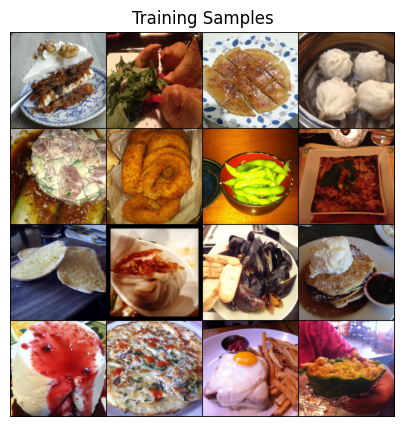

['waffles', 'caprese_salad', 'pancakes', 'dumplings', 'chicken_wings', 'chicken_curry', 'macarons', 'baby_back_ribs', 'clam_chowder', 'waffles', 'donuts', 'chocolate_mousse', 'cheesecake', 'french_fries', 'tuna_tartare', 'beet_salad']


In [11]:
# EXAMPLE TRAINING
print("Starting supervised training...")
sup_losses, sup_accuracies = train_supervised(model, train_loader, test_loader, num_epochs=50)

# Inference
with torch.no_grad():
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    # visualize the first 16
    visualize_image_samples(images[:16].to('cpu'), labels[:16].to('cpu'))
    print([class_names[i] for i in predicted[:16]])